# Load dataset

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

csv_path = os.path.join("data", "WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = pd.read_csv(csv_path)

print("Dataset path:", csv_path)
print("Shape:", df.shape)

df.head()

Dataset path: data/WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df_clean = df.copy()

df_clean["TotalCharges"] = df_clean["TotalCharges"].replace(" ", np.nan)
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

print("Missing TotalCharges after conversion:", df_clean["TotalCharges"].isna().sum())
if df_clean["TotalCharges"].isna().sum() > 0:
    display(df_clean[df_clean["TotalCharges"].isna()].head())

print("\nValue counts of tenure==0 among TotalCharges NA:")
print((df_clean[df_clean["TotalCharges"].isna()]["tenure"] == 0).sum())

df_clean["TotalCharges_filled"] = df_clean["TotalCharges"].fillna(
    df_clean["MonthlyCharges"] * df_clean["tenure"]
)


Missing TotalCharges after conversion: 11


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No



Value counts of tenure==0 among TotalCharges NA:
11

Done conversion. Using `df_clean` going forward for EDA.


# Clustering - Customer Segmentation based on Total Charges charged

## Data Preperation (Total Charges)

In [42]:
# --- 1. Data Preparation ---
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)

features = ["tenure", "MonthlyCharges", "TotalCharges"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Elbow Method to find k (Total Charges)

Running Elbow Method to find optimal k...
Elbow method plot saved as 'cluster_notebook_exports/elbow_method_plot.png'.


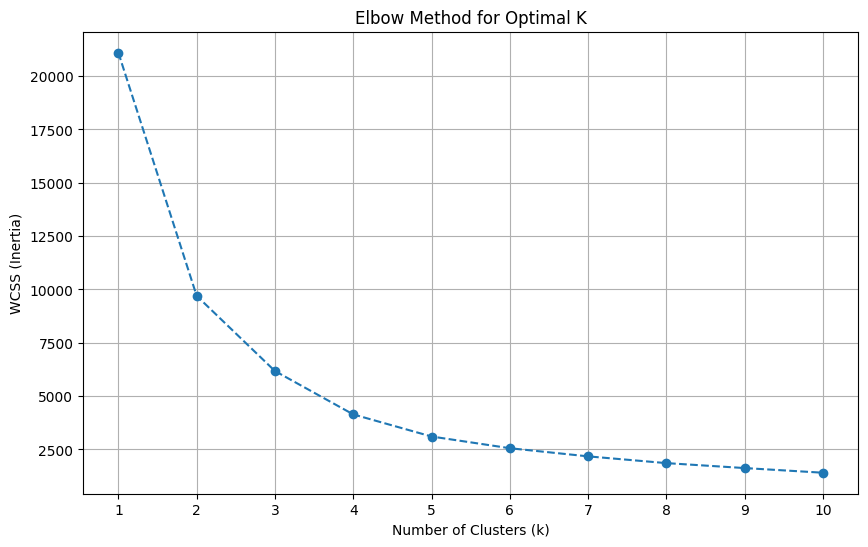

In [43]:
# --- 2. Elbow Method to Find Optimal K ---
print("Running Elbow Method to find optimal k...")
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker="o", linestyle="--")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(k_range)
plt.grid(True)
# Export to cluster_notebook_exports folder
export_dir = "cluster_notebook_exports"
os.makedirs(export_dir, exist_ok=True)
elbow_path = os.path.join(export_dir, "elbow_method_plot.png")
plt.savefig(elbow_path)
print(f"Elbow method plot saved as '{elbow_path}'.")
plt.show()

## Clustering (Total Charges)

In [44]:
# --- 3. Final KMeans Clustering ---
optimal_k = 4  # change if needed based on elbow plot
print(f"Running KMeans with k={optimal_k}...")

kmeans_final = KMeans(
    n_clusters=optimal_k, init="k-means++", n_init=10, random_state=42
)
clusters = kmeans_final.fit_predict(X_scaled)
df["Cluster"] = clusters

# --- 4. Cluster Analysis ---
print("\n--- Analysis of Segments (Mean values by cluster) ---")
print(df.groupby("Cluster")[features].mean())

if "Churn" in df.columns:
    print("\n--- Churn Rate by Cluster ---")
    print(df.groupby("Cluster")["Churn"].value_counts(normalize=True).unstack())

Running KMeans with k=4...

--- Analysis of Segments (Mean values by cluster) ---
            tenure  MonthlyCharges  TotalCharges
Cluster                                         
0        10.277123       31.777771    303.821875
1        59.530987       93.306224   5548.653887
2        53.585850       34.920147   1836.581320
3        15.445227       80.791201   1252.816564

--- Churn Rate by Cluster ---
Churn          No       Yes
Cluster                    
0        0.752358  0.247642
1        0.846113  0.153887
2        0.949957  0.050043
3        0.516938  0.483062


## Labelling Clusters (Total Charges)

In [45]:
# --- 6. Naming Customer Segments (Task 1b) ---
print("\n--- Task 1b: Naming Customer Segments ---")

cluster_features = ["tenure", "MonthlyCharges", "TotalCharges"]

try:
    # Sort clusters by spending level
    segment_analysis_means = (
        df.groupby("Cluster")["MonthlyCharges"].mean().reset_index()
    )
    sorted_segments = segment_analysis_means.sort_values(
        by="MonthlyCharges", ascending=True
    )

    print("\nSegments sorted by average MonthlyCharges:")
    print(sorted_segments)

    k = df["Cluster"].nunique()

    if k == 3:
        segment_names = ["Low Spenders", "Medium Spenders", "High Spenders"]
    elif k == 4:
        segment_names = [
            "Low Spenders",
            "Medium-Low Spenders",
            "Medium-High Spenders",
            "High Spenders",
        ]
    elif k == 5:
        segment_names = [
            "Lowest Spenders",
            "Low Spenders",
            "Medium Spenders",
            "High Spenders",
            "Highest Spenders",
        ]
    else:
        segment_names = [f"Segment {i+1} (Low-to-High)" for i in range(k)]

    mapping = dict(zip(sorted_segments["Cluster"], segment_names))

    print(f"\nMapping {k} cluster IDs to new names:")
    print(mapping)

    df["SegmentName"] = df["Cluster"].map(mapping)

    print("\nDataFrame with new 'SegmentName' column added:")
    print(df[["customerID", "MonthlyCharges", "Cluster", "SegmentName"]].head())

    # Save cluster assignments to export folder
    export_dir = "cluster_notebook_exports"
    os.makedirs(export_dir, exist_ok=True)
    clusters_csv = os.path.join(export_dir, "clustered_customers.csv")
    df[["customerID", "Cluster", "SegmentName"]].to_csv(clusters_csv, index=False)
    print(f"Cluster assignments saved to {clusters_csv}.")

    print("\n--- Final Segment Analysis (by Name) ---")
    final_analysis = df.groupby("SegmentName")[cluster_features].mean()
    print(final_analysis.sort_values(by="MonthlyCharges"))

except NameError as e:
    print(f"\nError: {e}")
    print("Please make sure you have run the main code block first.")
    print("This code requires the 'df' DataFrame with the 'Cluster' column.")
except KeyError as e:
    print(f"\nError: {e}")
    print("It looks like the 'Cluster' column does not exist in the 'df' DataFrame.")
    print("Please run the main code block (Task 1) first to create the clusters.")


--- Task 1b: Naming Customer Segments ---

Segments sorted by average MonthlyCharges:
   Cluster  MonthlyCharges
0        0       31.777771
2        2       34.920147
3        3       80.791201
1        1       93.306224

Mapping 4 cluster IDs to new names:
{0: 'Low Spenders', 2: 'Medium-Low Spenders', 3: 'Medium-High Spenders', 1: 'High Spenders'}

DataFrame with new 'SegmentName' column added:
   customerID  MonthlyCharges  Cluster           SegmentName
0  7590-VHVEG           29.85        0          Low Spenders
1  5575-GNVDE           56.95        2   Medium-Low Spenders
2  3668-QPYBK           53.85        0          Low Spenders
3  7795-CFOCW           42.30        2   Medium-Low Spenders
4  9237-HQITU           70.70        3  Medium-High Spenders
Cluster assignments saved to cluster_notebook_exports/clustered_customers.csv.

--- Final Segment Analysis (by Name) ---
                         tenure  MonthlyCharges  TotalCharges
SegmentName                                        

## Visualization (Total Charges)

Cluster scatter plot saved as 'cluster_notebook_exports/customer_segments_scatter.png'.


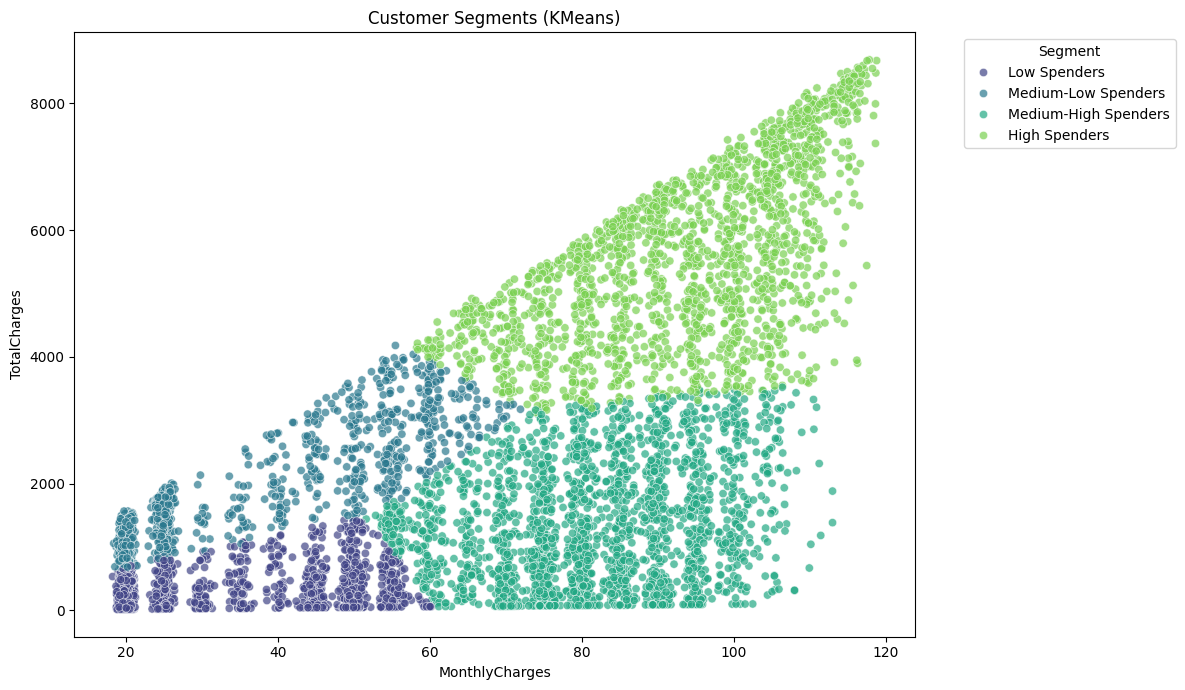

Cluster pie chart saved as 'cluster_notebook_exports/customer_segments_pie.png'.


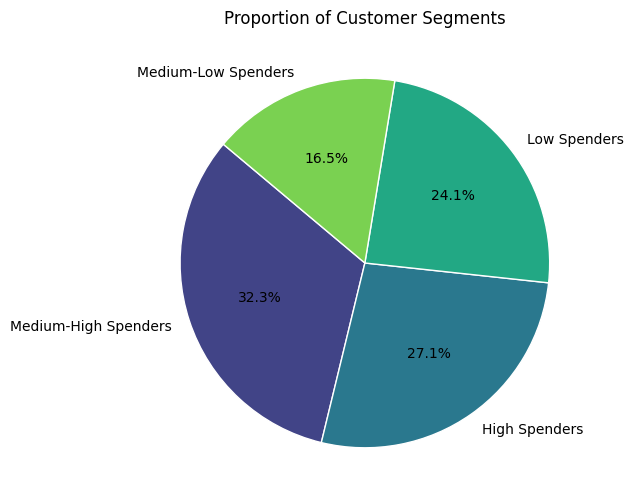

In [46]:
# Scatter plot of MonthlyCharges vs TotalCharges colored by segment names when available
plt.figure(figsize=(12, 7))
hue_col = 'SegmentName' if 'SegmentName' in df.columns else 'Cluster'
unique_vals = df[hue_col].unique()
palette = sns.color_palette('viridis', len(unique_vals))
sns.scatterplot(
    data=df,
    x="MonthlyCharges",
    y="TotalCharges",
    hue=hue_col,
    palette=palette,
    alpha=0.7,
)
plt.title("Customer Segments (KMeans)")
# Improve legend title
legend_title = 'Segment' if hue_col == 'SegmentName' else 'Cluster'
plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# Export directory for notebook outputs
export_dir = "cluster_notebook_exports"
os.makedirs(export_dir, exist_ok=True)
scatter_path = os.path.join(export_dir, "customer_segments_scatter.png")
plt.savefig(scatter_path)
print(f"Cluster scatter plot saved as '{scatter_path}'.")
plt.show()

# Pie chart showing proportion of customer segments
if 'Cluster' in df.columns:
    plt.figure(figsize=(8, 6))
    # Prefer human-friendly names if available
    if 'SegmentName' in df.columns:
        counts = df['SegmentName'].value_counts()
        labels = counts.index.tolist()
    else:
        counts = df['Cluster'].value_counts().sort_index()
        labels = [f"Cluster {i}" for i in counts.index.tolist()]
    colors = sns.color_palette('viridis', len(counts))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(edgecolor='w'))
    plt.title('Proportion of Customer Segments')
    pie_path = os.path.join(export_dir, 'customer_segments_pie.png')
    plt.savefig(pie_path)
    print(f"Cluster pie chart saved as '{pie_path}'.")
    plt.show()
else:
    print("No 'Cluster' column found. Run clustering cell first to create clusters.")

# Clustering - Customer Segmentation based on Tenure

## Data Preparation (Tenure)

In [47]:
features_t = ['tenure']
X_t = df[features_t].copy()
scaler_t = StandardScaler()
X_t_scaled = scaler_t.fit_transform(X_t)
print('Prepared tenure features; shape:', X_t_scaled.shape)

Prepared tenure features; shape: (7032, 1)


## Elbow Method to find k (Tenure)

Elbow method plot (tenure) saved as cluster_notebook_exports/tenure_elbow_plot.png


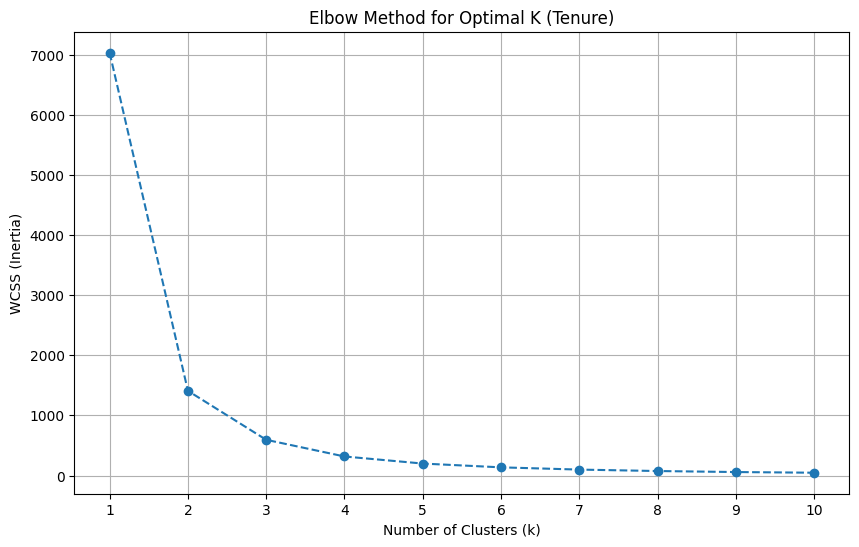

In [48]:
wcss_t = []
k_range_t = range(1, 11)
for k in k_range_t:
    kmeans_t = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    kmeans_t.fit(X_t_scaled)
    wcss_t.append(kmeans_t.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(k_range_t, wcss_t, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (Tenure)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range_t)
plt.grid(True)
# save to export dir
export_dir = 'cluster_notebook_exports'
os.makedirs(export_dir, exist_ok=True)
elbow_t_path = os.path.join(export_dir, 'tenure_elbow_plot.png')
plt.savefig(elbow_t_path)
print(f'Elbow method plot (tenure) saved as {elbow_t_path}')
plt.show()

## Clustering (Tenure)

In [49]:
# --- Tenure: 3. Final KMeans Clustering ---
optimal_k_t = 4  # adjust after inspecting the tenure elbow plot
print(f'Running KMeans (tenure) with k={optimal_k_t}...')
kmeans_final_t = KMeans(n_clusters=optimal_k_t, init="k-means++", n_init=10, random_state=42)
clusters_t = kmeans_final_t.fit_predict(X_t_scaled)
df['Cluster_Tenure'] = clusters_t
print('--- Analysis: Mean tenure by cluster ---')
print(df.groupby('Cluster_Tenure')['tenure'].mean())
if 'Churn' in df.columns:
    print('--- Churn Rate by Tenure Cluster ---')
    print(df.groupby('Cluster_Tenure')['Churn'].value_counts(normalize=True).unstack())

Running KMeans (tenure) with k=4...
--- Analysis: Mean tenure by cluster ---
Cluster_Tenure
0    46.825792
1     5.819032
2    66.580299
3    25.488550
Name: tenure, dtype: float64
--- Churn Rate by Tenure Cluster ---
Churn                 No       Yes
Cluster_Tenure                    
0               0.825038  0.174962
1               0.538024  0.461976
2               0.924776  0.075224
3               0.761450  0.238550


## Labelling Clusters (Tenure)

In [50]:
# --- Tenure: 4. Naming Tenure-based Segments ---
try:
    seg_means_t = df.groupby('Cluster_Tenure')['tenure'].mean().reset_index()
    sorted_seg_t = seg_means_t.sort_values(by='tenure', ascending=True)
    print('Tenure clusters sorted by mean tenure:')
    print(sorted_seg_t)
    k_t = df['Cluster_Tenure'].nunique()
    if k_t == 3:
        names_t = ['New', 'Established', 'Long-term']
    elif k_t == 4:
        names_t = ['Very New', 'New', 'Established', 'Long-term']
    elif k_t == 5:
        names_t = ['Very New', 'New', 'Medium-term', 'Established', 'Long-term']
    else:
        names_t = [f'TenureSegment {i+1}' for i in range(k_t)]
    mapping_t = dict(zip(sorted_seg_t['Cluster_Tenure'], names_t))
    print('Mapping tenure cluster IDs to names:')
    print(mapping_t)
    df['SegmentName_Tenure'] = df['Cluster_Tenure'].map(mapping_t)
    # save tenure cluster assignments
    export_dir = 'cluster_notebook_exports'
    os.makedirs(export_dir, exist_ok=True)
    tenure_csv = os.path.join(export_dir, 'clustered_customers_tenure.csv')
    df[['customerID', 'Cluster_Tenure', 'SegmentName_Tenure']].to_csv(tenure_csv, index=False)
    print(f'Tenure cluster assignments saved to {tenure_csv}')
    print('--- Tenure Segment Analysis (by Name) ---')
    print(df.groupby('SegmentName_Tenure')['tenure'].mean().sort_values())
except Exception as e:
    print('Error during tenure labelling:', e)

Tenure clusters sorted by mean tenure:
   Cluster_Tenure     tenure
1               1   5.819032
3               3  25.488550
0               0  46.825792
2               2  66.580299
Mapping tenure cluster IDs to names:
{1: 'Very New', 3: 'New', 0: 'Established', 2: 'Long-term'}
Tenure cluster assignments saved to cluster_notebook_exports/clustered_customers_tenure.csv
--- Tenure Segment Analysis (by Name) ---
SegmentName_Tenure
Very New        5.819032
New            25.488550
Established    46.825792
Long-term      66.580299
Name: tenure, dtype: float64


## Visualization (Tenure)

Tenure cluster scatter saved to cluster_notebook_exports/customer_segments_tenure_scatter.png


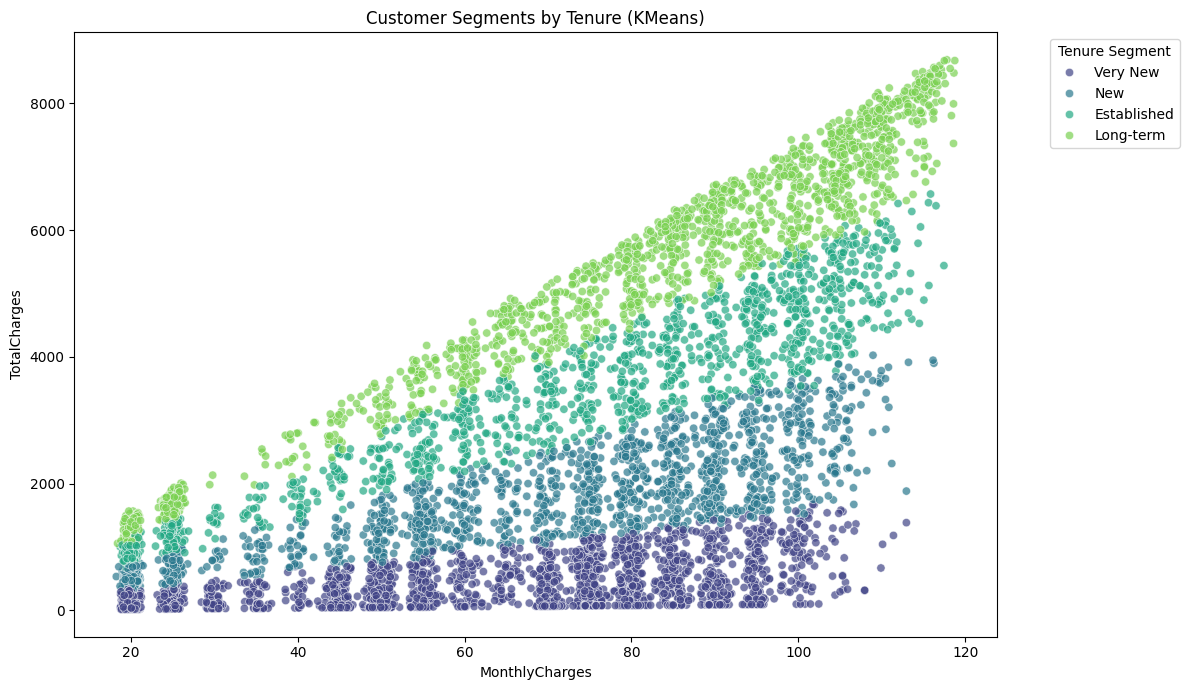

Tenure pie chart saved to cluster_notebook_exports/customer_segments_tenure_pie.png


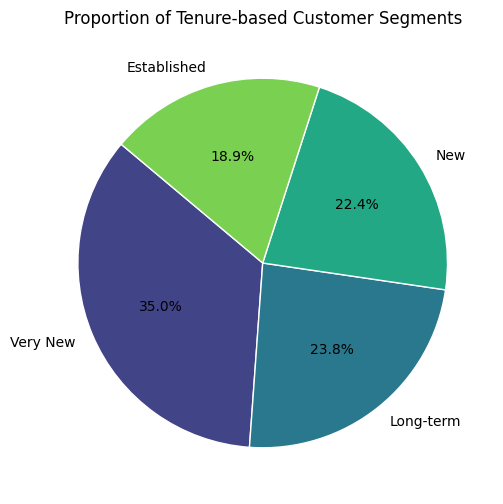

In [51]:
# --- Tenure: 5. Visualization ---
# Scatter plot to show how tenure-based clusters relate to charges
plt.figure(figsize=(12, 7))
hue_t = 'SegmentName_Tenure' if 'SegmentName_Tenure' in df.columns else 'Cluster_Tenure'
vals_t = df[hue_t].unique()
palette_t = sns.color_palette('viridis', len(vals_t))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue=hue_t, palette=palette_t, alpha=0.7)
plt.title('Customer Segments by Tenure (KMeans)')
plt.legend(title='Tenure Segment' if hue_t=='SegmentName_Tenure' else 'Cluster_Tenure', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
export_dir = 'cluster_notebook_exports'
os.makedirs(export_dir, exist_ok=True)
scatter_t_path = os.path.join(export_dir, 'customer_segments_tenure_scatter.png')
plt.savefig(scatter_t_path)
print(f'Tenure cluster scatter saved to {scatter_t_path}')
plt.show()
# Pie chart for tenure clusters
if 'Cluster_Tenure' in df.columns:
    plt.figure(figsize=(8,6))
    if 'SegmentName_Tenure' in df.columns:
        counts_t = df['SegmentName_Tenure'].value_counts()
        labels_t = counts_t.index.tolist()
    else:
        counts_t = df['Cluster_Tenure'].value_counts().sort_index()
        labels_t = [f'Cluster_Tenure {i}' for i in counts_t.index.tolist()]
    colors_t = sns.color_palette('viridis', len(counts_t))
    plt.pie(counts_t, labels=labels_t, autopct='%1.1f%%', startangle=140, colors=colors_t, wedgeprops=dict(edgecolor='w'))
    plt.title('Proportion of Tenure-based Customer Segments')
    pie_t_path = os.path.join(export_dir, 'customer_segments_tenure_pie.png')
    plt.savefig(pie_t_path)
    print(f'Tenure pie chart saved to {pie_t_path}')
    plt.show()
else:
    print('No Cluster_Tenure column found. Run tenure clustering cell first.')